# DraftKings for MLB

This notebook performs exploratory data analysis for a model to player DraftKings for the MLB. The model will focus on optimizing a set of multiple entries to win large Guaranteed Prize Pool contests. The payout structure for these contests are top heavy; i.e. the top 10% of entries wins nearly all of the money, and the top single player wins a large portion of the money. Therefore, we focus on maximizing the probability that a single lineup in our set hits an estimated winning target score. 

In [1]:
import os
import subprocess
import glob
import json
import copy
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import expon, lognorm, gamma, truncnorm, norm, chi, chi2, triang, rv_discrete, rv_continuous, chisquare, entropy
from scipy.optimize import minimize, basinhopping, fsolve, root

from sklearn.decomposition import PCA

from functools import partial

from IPython.display import display

%matplotlib inline

In [2]:
# Configurations
data_dir = '/Users/tom/Projects/Portfolio/data/mlb'
raw_data_dir = os.path.join(data_dir, 'retrosheet-raw')

# Attributes to extract from RetroSheet files
included_attributes = {
    'boxscore': ['game_id', 'date', 'home', 'visitor', 'temperature', 'wind_direction', 'wind_speed'],
    'players': ['team'],
    'player': ['id', 'slot', 'seq', 'pos'],
    'batting': ['ab', 'r', 'h', 'd', 't', 'hr', 'bi', 'bi2out', 'bb', 'ibb', 'so', 'hp', 'sh', 'sf', 'sb', 'cs'],
    'pitching': ['team'],
    'pitcher': ['id', 'gs', 'cg', 'sho', 'gf', 'outs', 'bf', 'h', 'r', 'er', 'hr', 'bb', 'ibb', 'so', 'wp', 'bk', 'hb', 'gb', 'fb', 'dec'],
}

raw_batting_file = os.path.join(data_dir, 'batting-raw.p')
raw_pitching_file = os.path.join(data_dir, 'pitching-raw.p')

regenerate_files = False

In [3]:
# Use the Chadwick utility to parse play-by-play data into player/game level box scores
def parse_boxscore(boxscore, included_attributes):
    """
    Parse a boxscore into player level data as a list of dictionaries that can be read into pandas
    
    :param boxscore: an xml.etree.ElementTree object at the root of the boxscore
    :param included_attributes: the attributes for each player to extract
    """
    batting_out, pitching_out = [], []
    
    # Data that will apply to all players
    game_data = {k:v for k, v in boxscore.attrib.items() if k in included_attributes['boxscore']}
    
    # Parse the batting
    for players in boxscore.findall('players'):
        players_data = copy.copy(game_data)
        players_data.update({k:v for k, v in players.attrib.items() if k in included_attributes['players']})
        for player in players.findall('player'):
            player_data = copy.copy(players_data)
            player_data.update({k:v for k, v in player.attrib.items() if k in included_attributes['player']})
            
            batting_root = player.find('batting')
            if batting_root is not None:
                player_data.update({k:v for k, v in batting_root.attrib.items() if k in included_attributes['batting']})

                batting_out.append(player_data)
            
    # Parse the pitching
    for pitching in boxscore.findall('pitching'):
        pitching_data = copy.copy(game_data)
        pitching_data.update({k:v for k, v in pitching.attrib.items() if k in included_attributes['pitching']})
        for pitcher in pitching.findall('pitcher'):
            pitcher_data = copy.copy(pitching_data)
            pitcher_data.update({k:v for k, v in pitcher.attrib.items() if k in included_attributes['pitcher']})

            pitching_out.append(pitcher_data)
    
    return batting_out, pitching_out
    

def parse_event_files(raw_data_dir, included_attributes):
    batting, pitching = [], []
    
    for event_file in glob.glob(os.path.join(raw_data_dir, '*.EV[AN]')):
        base_name = os.path.basename(event_file)
        year = base_name[:4]

        completed_process = subprocess.run(['cwbox', '-y', year, '-X', base_name], cwd=raw_data_dir, stdout=subprocess.PIPE)
        data = '<xml>' + completed_process.stdout.decode('utf-8') + '</xml>'

        root = ET.fromstring(data)
        
        for child in root:
            assert child.tag == 'boxscore'
            boxscore_batting, boxscore_pitching = parse_boxscore(child, included_attributes)
            batting += boxscore_batting
            pitching += boxscore_pitching
        
    return batting, pitching


In [4]:
# Parse out the Retrosheet files to pandas DataFrames at the player/game level
if regenerate_files:
    batting, pitching = parse_event_files(raw_data_dir, included_attributes)

    df_batting = pd.DataFrame(batting)
    df_pitching = pd.DataFrame(pitching)
    
    batting_numeric_cols = ['temperature', 'wind_speed', 'slot', 'seq', 'pos', 'r', 'h', 'd', 't', 'hr', 'bi', 'bi2out', 'bb', 'ibb', 'so', 'hp', 'sh', 'sf', 'sb', 'cs']
    pitching_numeric_cols = ['temperature', 'wind_speed', 'gs', 'cg', 'sho', 'gf', 'outs', 'bf', 'h', 'r', 'er', 'hr', 'bb', 'ibb', 'so', 'wp', 'bk', 'hb', 'gb', 'fb']
    
    df_batting[batting_numeric_cols] = df_batting[batting_numeric_cols].apply(pd.to_numeric, errors='coerce')
    df_pitching[pitching_numeric_cols] = df_pitching[pitching_numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    df_batting['date'] = pd.to_datetime(df_batting['date'], format='%Y/%m/%d')
    df_pitching['date'] = pd.to_datetime(df_pitching['date'], format='%Y/%m/%d')
    
    df_batting.to_pickle(raw_batting_file)
    df_pitching.to_pickle(raw_pitching_file)
                          
else:
    df_batting = pd.read_pickle(raw_batting_file)
    df_pitching = pd.read_pickle(raw_pitching_file)

In [5]:
# Calculate draftkings points that were scored by each player
df_batting['s'] = df_batting['h'] - (df_batting['d'] + df_batting['t'] + df_batting['hr'])
df_batting['pts'] = 3 * df_batting['s'] + \
                    5 * df_batting['d'] + \
                    8 * df_batting['t'] + \
                    10 * df_batting['hr'] + \
                    2 * df_batting['bi'] + \
                    2 * df_batting['bb'] + \
                    2 * df_batting['hp'] + \
                    5 * df_batting['sb']

df_pitching['ip'] = df_pitching['outs'] / 3
df_pitching['nono'] = (df_pitching['h'] == 0) & (df_pitching['cg'] > 0)
df_pitching['pts'] = 2.25 * df_pitching['ip'] + \
                     2 * df_pitching['so'] + \
                     4 * df_pitching['wp'] + \
                     -2 * df_pitching['er'] + \
                     -0.6 * df_pitching['h'] + \
                     -0.6 * df_pitching['bb'] + \
                     -0.6 * df_pitching['hb'] + \
                     2.5 * df_pitching['cg'] + \
                     2.5 * df_pitching['sho'] + \
                     5 * df_pitching['nono']
                     
                  

# Modeling Dependency Between Players
Our goal is to win large contests with top-heavy payouts, so the optimization problem we'd like to solve is not to maximize an expected value, but to maximize the probability of reaching a high target score. This becomes more likely if our players are highly correlated. Going one step further, we are most interested in upper tail dependence.

Intuitively, batters that bat near each other should be correlated. For example, if batter 1 gets on base, then batter 2 hits him home, batter 1 will score for getting a run, and batter two will also score for an RBI. Similarly, they both face the same starting pitcher and bullpen, so they should both perform well against bad pitching together, and poorly against good pitching together. 

Similarly, batters should correlate negatively with the opposing pitcher, as points for the batter directly means negative points for the pitcher, and points for the pitcher (outs, strike outs) mean no points for the batter. We would expect very strong tail dependence, with a great game for the pitcher meaning poor games for the batters (e.g. a perfect game for the pitcher would imply all the batters score 0). 

In [6]:
# Look at how different starting batting order slots correlate with each other and with the opposing pitcher
df_batting['is_home'] = df_batting['team'] == df_batting['home']
df_pitching['is_home'] = df_pitching['team'] == df_pitching['home']

df_b = df_batting[df_batting['seq'] == 1][['game_id', 'is_home', 'slot', 'pts']]  # seq == 1 indicates the starter

df_p = df_pitching[df_pitching['gs'] == 1][['game_id', 'is_home', 'pts']]

# We want to join the batting lineup against the other team's pitcher, so flip is_home
df_p['is_home'] = ~df_p['is_home']
df_p['slot'] = 10

# Merge the two data sets
df = pd.concat([df_b, df_p], ignore_index=True)
df = df.set_index(['game_id', 'is_home', 'slot'])
df = df.unstack(level='slot')

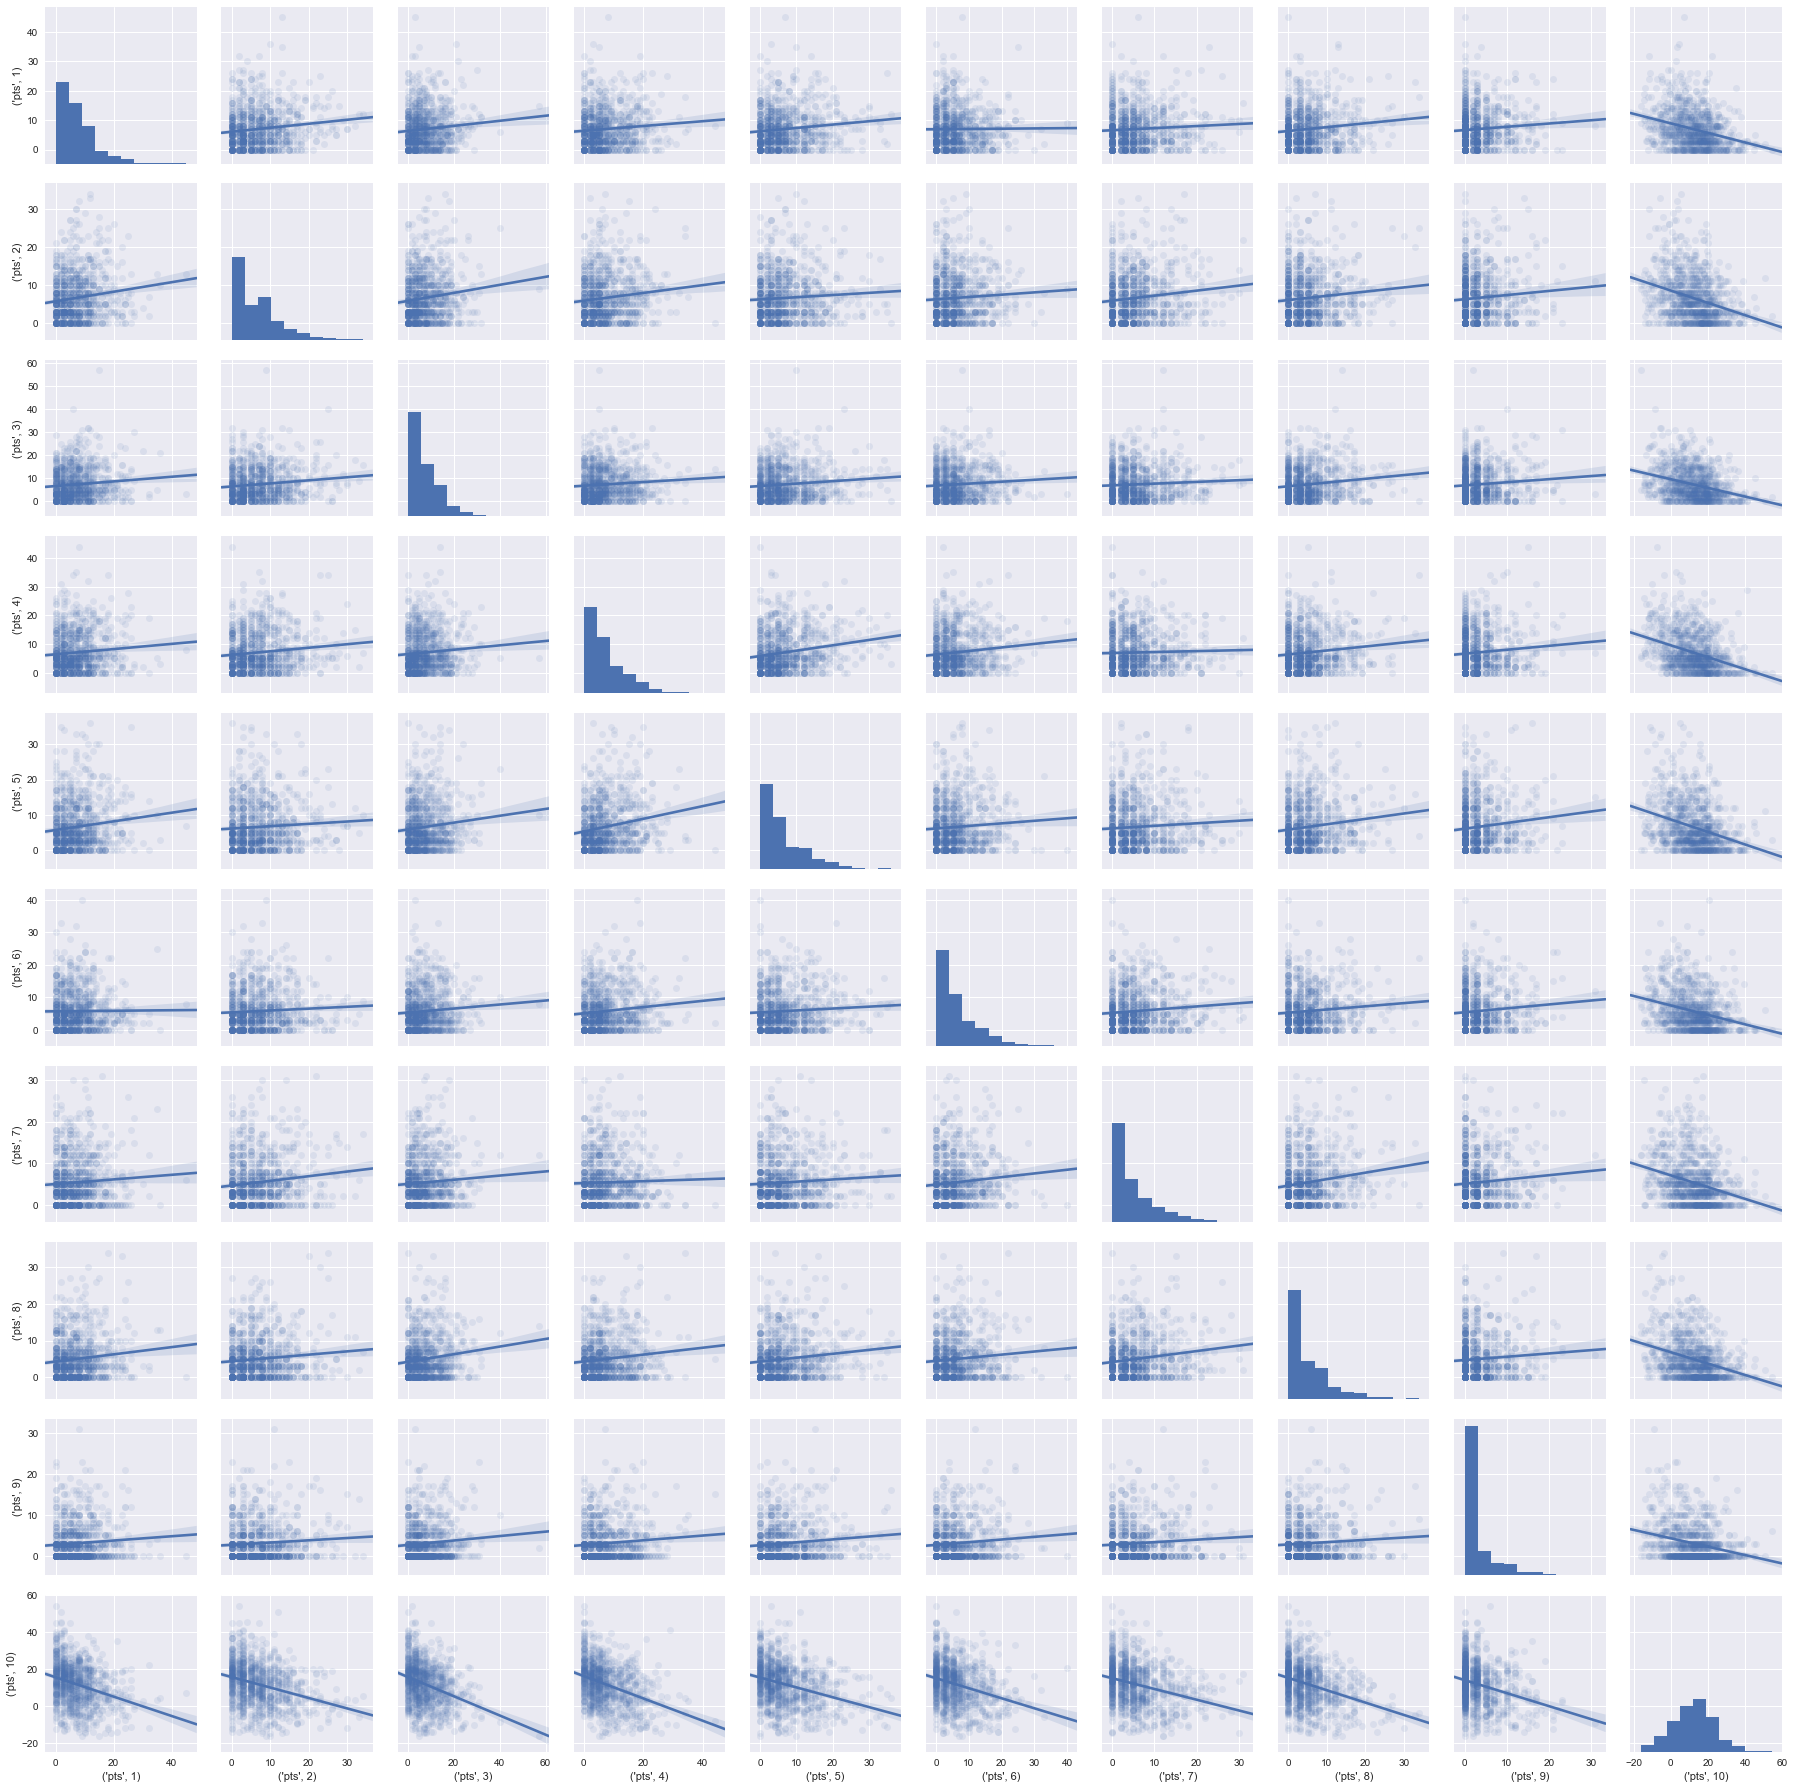

In [7]:
# Look at correlations
sns.pairplot(df.sample(1000), kind='reg', plot_kws={'scatter_kws': {'alpha': 0.1}})

In [8]:
display(df.corr())
display(df.corr(method='kendall'))
display(df.corr(method='spearman'))

pts                                                    \
slot            1         2         3         4         5         6    
    slot                                                               
pts 1     1.000000  0.113796  0.116297  0.094556  0.080713  0.081902   
    2     0.113796  1.000000  0.108527  0.098930  0.091677  0.083313   
    3     0.116297  0.108527  1.000000  0.099171  0.095226  0.088769   
    4     0.094556  0.098930  0.099171  1.000000  0.093641  0.089434   
    5     0.080713  0.091677  0.095226  0.093641  1.000000  0.096405   
    6     0.081902  0.083313  0.088769  0.089434  0.096405  1.000000   
    7     0.089688  0.084191  0.080661  0.084909  0.096527  0.098392   
    8     0.101098  0.094996  0.087710  0.086115  0.088912  0.100882   
    9     0.076790  0.085894  0.070755  0.062523  0.066583  0.070176   
    10   -0.301362 -0.305580 -0.322721 -0.327835 -0.316474 -0.305190   

                                                  
slot            7         8         9         10  
    slot                                          
pts 1     0.089688  0.101098  0.076790 -0.301362  
    2     0.084191  0.094996  0.085894 -0.305580  
    3     0.080661  0.087710  0.070755 -0.322721  
    4     0.084909  0.086115  0.062523 -0.327835  
    5     0.096527  0.088912  0.066583 -0.316474  
    6     0.098392  0.100882  0.070176 -0.305190  
    7     1.000000  0.104702  0.090911 -0.299426  
    8     0.104702  1.000000  0.088333 -0.294430  
    9     0.090911  0.088333  1.000000 -0.261919  
    10   -0.299426 -0.294430 -0.261919  1.000000

pts                                                    \
slot            1         2         3         4         5         6    
    slot                                                               
pts 1     1.000000  0.081502  0.087138  0.073158  0.061786  0.063352   
    2     0.081502  1.000000  0.083067  0.078409  0.070118  0.062809   
    3     0.087138  0.083067  1.000000  0.079038  0.075998  0.067521   
    4     0.073158  0.078409  0.079038  1.000000  0.075231  0.071528   
    5     0.061786  0.070118  0.075998  0.075231  1.000000  0.074217   
    6     0.063352  0.062809  0.067521  0.071528  0.074217  1.000000   
    7     0.069725  0.065220  0.063742  0.065059  0.078409  0.077540   
    8     0.077978  0.072560  0.068922  0.066607  0.072102  0.078971   
    9     0.056426  0.066443  0.057596  0.049303  0.050465  0.055100   
    10   -0.215329 -0.218473 -0.230847 -0.235751 -0.227124 -0.218048   

                                                  
slot            7         8         9         10  
    slot                                          
pts 1     0.069725  0.077978  0.056426 -0.215329  
    2     0.065220  0.072560  0.066443 -0.218473  
    3     0.063742  0.068922  0.057596 -0.230847  
    4     0.065059  0.066607  0.049303 -0.235751  
    5     0.078409  0.072102  0.050465 -0.227124  
    6     0.077540  0.078971  0.055100 -0.218048  
    7     1.000000  0.082292  0.069229 -0.217693  
    8     0.082292  1.000000  0.058488 -0.216091  
    9     0.069229  0.058488  1.000000 -0.196033  
    10   -0.217693 -0.216091 -0.196033  1.000000

pts                                                    \
slot            1         2         3         4         5         6    
    slot                                                               
pts 1     1.000000  0.112851  0.121270  0.101735  0.085543  0.087231   
    2     0.112851  1.000000  0.115362  0.108708  0.096639  0.086229   
    3     0.121270  0.115362  1.000000  0.110222  0.105429  0.093202   
    4     0.101735  0.108708  0.110222  1.000000  0.104212  0.098533   
    5     0.085543  0.096639  0.105429  0.104212  1.000000  0.101655   
    6     0.087231  0.086229  0.093202  0.098533  0.101655  1.000000   
    7     0.095549  0.089064  0.087630  0.089205  0.107001  0.105289   
    8     0.106218  0.098516  0.094156  0.090800  0.097768  0.106598   
    9     0.073734  0.086679  0.075554  0.064517  0.065718  0.071452   
    10   -0.307567 -0.310944 -0.330143 -0.335861 -0.322444 -0.308402   

                                                  
slot            7         8         9         10  
    slot                                          
pts 1     0.095549  0.106218  0.073734 -0.307567  
    2     0.089064  0.098516  0.086679 -0.310944  
    3     0.087630  0.094156  0.075554 -0.330143  
    4     0.089205  0.090800  0.064517 -0.335861  
    5     0.107001  0.097768  0.065718 -0.322444  
    6     0.105289  0.106598  0.071452 -0.308402  
    7     1.000000  0.110517  0.089349 -0.306393  
    8     0.110517  1.000000  0.075110 -0.302571  
    9     0.089349  0.075110  1.000000 -0.264715  
    10   -0.306393 -0.302571 -0.264715  1.000000

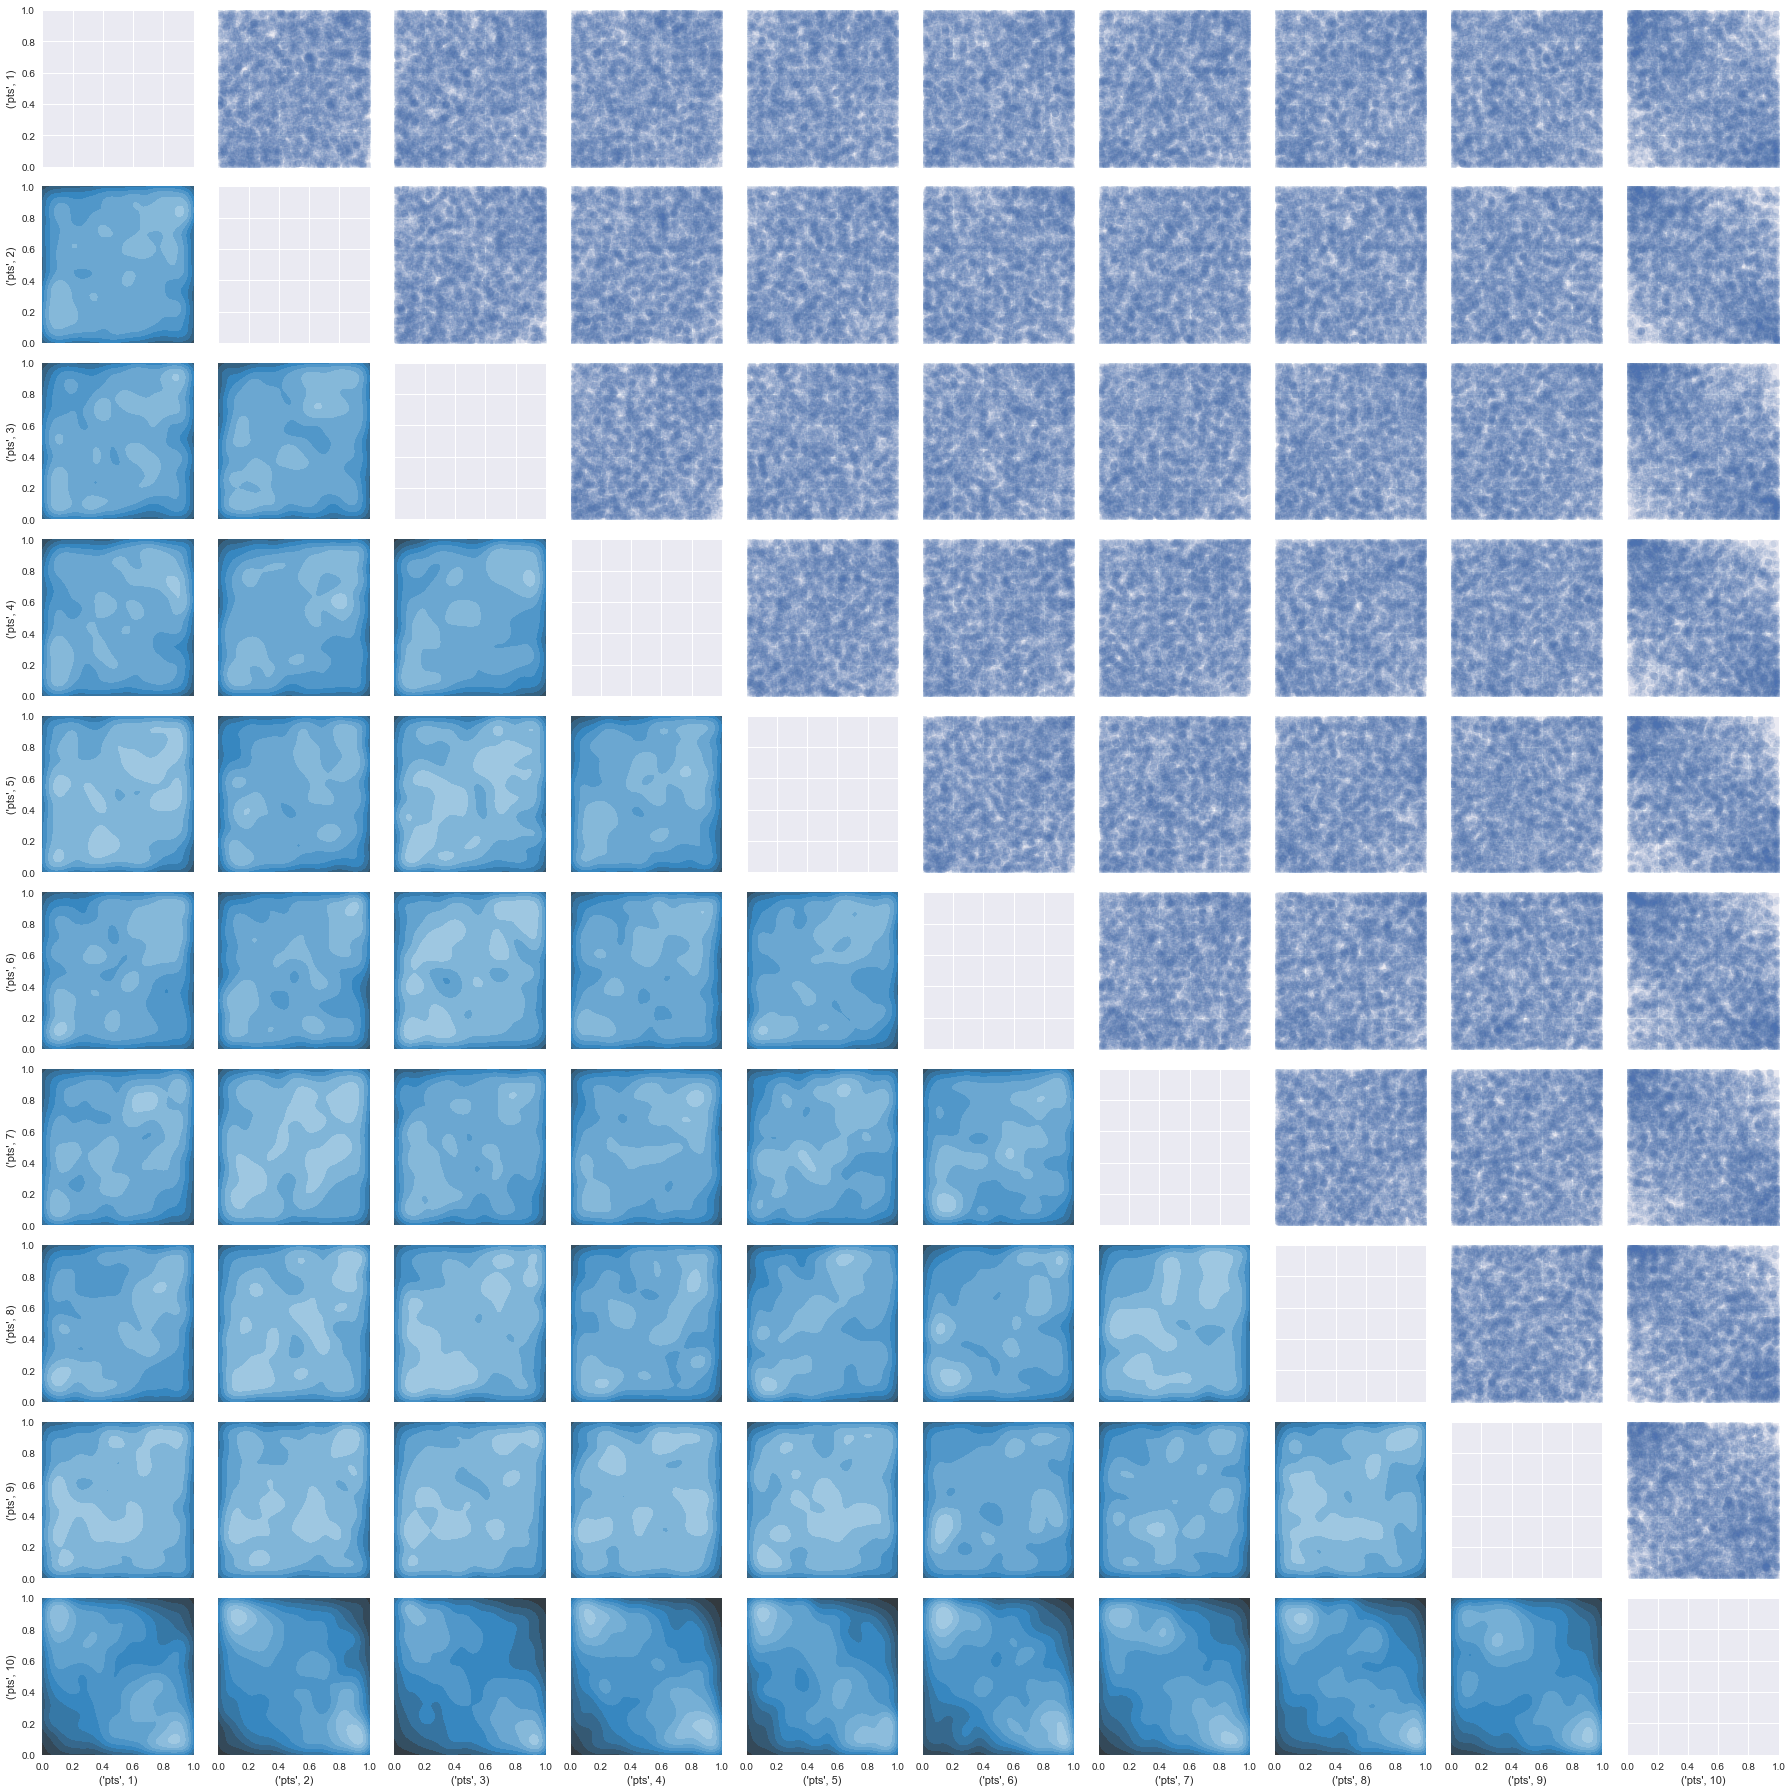

In [9]:
# Look for tail dependence by looking at quantile vs quantile
# Use jittering to get data off discrete lines
ranks = df.applymap(lambda x: x + np.random.rand()/1000).rank(pct=True).sample(5000)
g = sns.PairGrid(ranks)
g.set(xlim=(0, 1), ylim=(0, 1))
g.map_lower(sns.kdeplot, cmap="Blues_d", shade=True)
g.map_upper(plt.scatter, alpha=0.1)

Our assumptions seem to hold. 

We will use an empirical copula from our data to model the dependence. 

# Modeling Individual Player Distributions

The beauty of using a copula to model dependency is that we're free to model individual player distributions independently. 

count    171318.000000
mean         11.898686
std          10.956473
min         -27.100000
25%           4.550000
50%          12.100000
75%          19.100000
max          66.250000
Name: pts, dtype: float64

0.0058664359473765693

0.062340055621233972

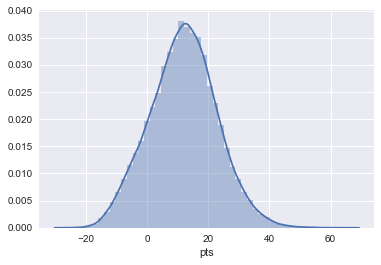

In [10]:
# First look at pitchers starting pitchers

starting_pitchers = df_pitching[df_pitching['gs'] == 1]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())


Shape, skewness, and kurtosis indicate that the pitching data very closely follows a normal distribution. Let's see if this holds for individual pitchers

count    603.000000
mean      22.634909
std       13.867886
min      -19.150000
25%       13.750000
50%       22.600000
75%       31.800000
max       58.450000
Name: pts, dtype: float64

-0.14826675723744209

-0.13314131105935623

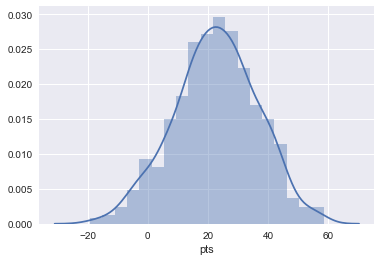

In [11]:
# Let's look at a couple good pitchers and a couple average pitchers

# Randy Johnson -- All time great
starting_pitchers = df_pitching[(df_pitching['gs'] == 1) & (df_pitching['id'] == 'johnr005')]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())

count    409.000000
mean      22.005623
std       12.530638
min      -14.400000
25%       13.300000
50%       22.500000
75%       30.350000
max       54.050000
Name: pts, dtype: float64

0.0018784189350422587

-0.15726554661626371

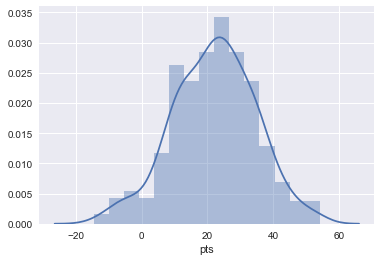

In [12]:
# Pedro Martinez -- All time great
starting_pitchers = df_pitching[(df_pitching['gs'] == 1) & (df_pitching['id'] == 'martp001')]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())

count    290.000000
mean      23.359310
std       11.001634
min      -10.400000
25%       17.387500
50%       23.650000
75%       30.100000
max       60.250000
Name: pts, dtype: float64

0.76586751125182451

-0.15172228151104675

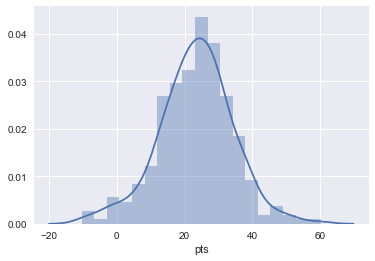

In [13]:
# Clayton Kershaw -- Current great
starting_pitchers = df_pitching[(df_pitching['gs'] == 1) & (df_pitching['id'] == 'kersc001')]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())

count    463.000000
mean      11.985313
std       10.030839
min      -13.450000
25%        5.400000
50%       12.900000
75%       18.550000
max       48.150000
Name: pts, dtype: float64

0.12531390796754627

0.012752917681843154

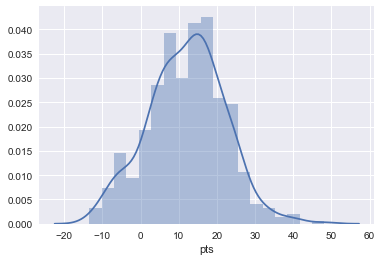

In [14]:
# Tim Wakefield -- Great knuckleballer
starting_pitchers = df_pitching[(df_pitching['gs'] == 1) & (df_pitching['id'] == 'waket001')]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())

count    214.000000
mean      13.295327
std        9.992451
min      -12.900000
25%        7.275000
50%       14.175000
75%       19.912500
max       40.850000
Name: pts, dtype: float64

0.11448690154306895

-0.16791923725983263

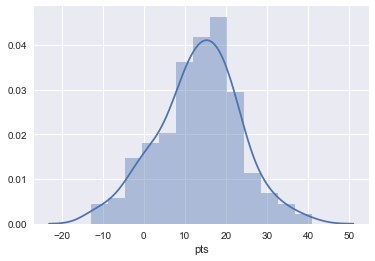

In [15]:
# Doug Fister -- Average to bad
starting_pitchers = df_pitching[(df_pitching['gs'] == 1) & (df_pitching['id'] == 'fistd001')]['pts']

sns.distplot(starting_pitchers)
display(starting_pitchers.describe())
display(starting_pitchers.kurtosis())
display(starting_pitchers.skew())

All pitchers have approximately normally distributed data, so we'll leave it at that. 

Rotogrinders will provide a mean and standard deviation for their projections, so we can use these directly with the method of moments to estimate probability distributions. 

count    1.541862e+06
mean     6.026119e+00
std      6.073712e+00
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      6.400000e+01
Name: pts, dtype: float64

2.4448565844677264

1.423031544888536

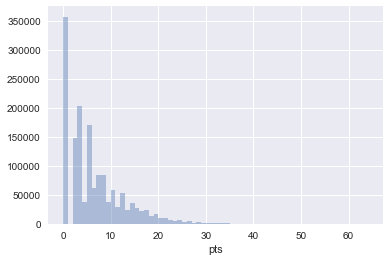

In [16]:
# Look at all hitters (in the starting lineup)
batters = df_batting[df_batting['seq'] == 1]['pts']

sns.distplot(batters, kde=False, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    1782.000000
mean        8.382716
std         7.889288
min         0.000000
25%         2.000000
50%         5.000000
75%        14.000000
max        46.000000
Name: pts, dtype: float64

1.2420600670908826

1.1823206133045203

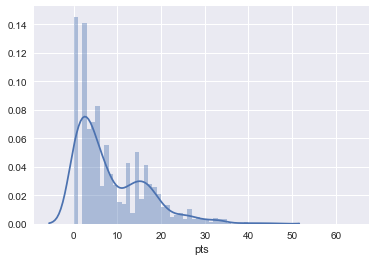

In [17]:
# Let's look at different types of hitters. E.g. good, bad, power, etc.

# Mark McGwire -- All time great power hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'mcgwm001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    2848.000000
mean        9.622893
std         7.906927
min         0.000000
25%         3.000000
50%         8.000000
75%        14.000000
max        46.000000
Name: pts, dtype: float64

0.71998627195515708

0.98193431988963242

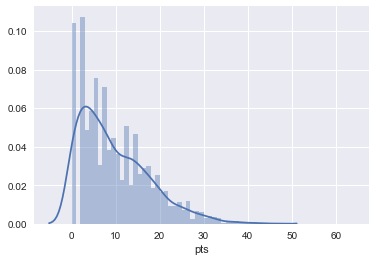

In [18]:
# Barry Bonds -- All time on-base and power hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'bondb001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    2280.000000
mean        7.154825
std         6.025918
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        36.000000
Name: pts, dtype: float64

1.4042658118111921

1.1314118997078695

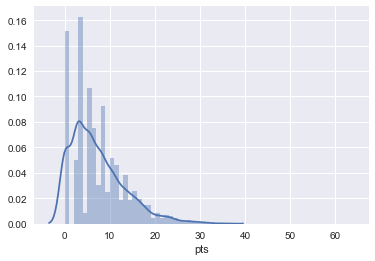

In [19]:
# Ichiro Suzuki -- All time on-base hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'suzui001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    2801.000000
mean        9.105677
std         7.233324
min         0.000000
25%         3.000000
50%         8.000000
75%        13.000000
max        51.000000
Name: pts, dtype: float64

0.93357360630355579

0.94963362679087737

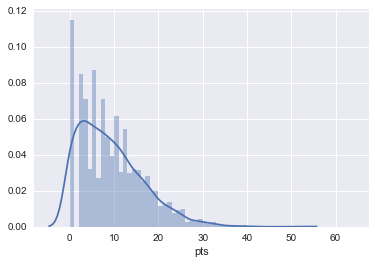

In [20]:
# Ricky Henderson -- All time on-base hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'hendr001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    914.000000
mean       9.110503
std        7.324271
min        0.000000
25%        3.000000
50%        7.500000
75%       14.000000
max       41.000000
Name: pts, dtype: float64

0.6167857492625326

0.91678292055496202

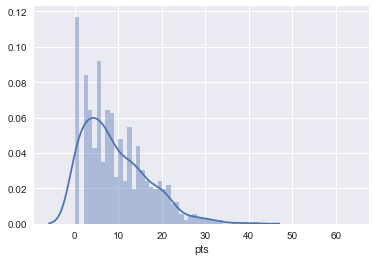

In [21]:
# Mike Trout -- Great all around hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'troum001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

count    526.000000
mean       6.414449
std        6.897018
min        0.000000
25%        0.000000
50%        5.000000
75%       10.000000
max       34.000000
Name: pts, dtype: float64

1.6126545778011687

1.3531283598982622

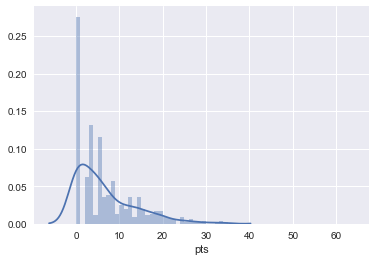

In [22]:
# Rougned Odor -- A pretty bad hitter
batters = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == 'odorr001')]['pts']

sns.distplot(batters, bins=list(range(65)))
display(batters.describe())
display(batters.kurtosis())
display(batters.skew())

So, distributions for batters are far from normally distributed. For the most part, they look exponential, with a hump around 10 for power hitters (most likely indicating games where they have a homerun).

To model this accurately, we will create a custom mixed probability distribution and fit it to player's historical data using MLE. 

From our live projection data, we will have a mean and standard deviation only, so our mixture model will have too many degrees of freedom to use the method of moments to fit a distribution directly. Therefore, we will use PCA on the parameters of the fitted distributions and solve for mean and variance from the principal components. Then, when we can perform the reverse process and construct our principal components from mean and variance, which we can then use to reconstruct the distribution parameters.

### Mixture models
Let $X$ be a random variable for the number of fantasy points in a game by a given batter. Then we can model the continuous analogue of the pmf as

$
f_X(x) = wf_{EXP}(x; \lambda) + (1 - w)\phi(x; \mu, \sigma))
$

where $f_{EXP}$ is the pmf of the exponential distribution and $\phi$ is the pmf of a Gaussian distribution.

Our actual data is discrete, taking only whole number values. So, we have to figure out how to discretize our data. The most simple idea would be to squish all the probability at integer mid-points down to the integer. E.g. all the density between 2.5 and 3.5 becomes a discrete point mass at 3. However, this ignores the jagged effect that we see in the true data (e.g. hits are more common than walks, so $P(3) > P(2)$, even though the distribution generally trends downward). So, we'll encorporate the ratios of the original data values into the discretization process. Basically, we can take two adjacent points from the original data, and the discretization cutoff between them will be determined by the ratios of their point masses. Concretely, let $d(x)$ map the continuous value $x$ to it's discrete analogue $d(x)$, then we define

$
d(x) = \begin{cases}
    min(max(0, \lfloor x \rfloor), 65) & , x \leq \Bigl( {{p_{\lfloor x \rfloor}} \over {p_{\lfloor x \rfloor} + p_{\lceil x \rceil}}} \Bigr) (\lceil x \rceil - \lfloor x \rfloor) + \lceil x \rceil \\
    min(max(0, \lceil x \rceil), 65) & , x > \Bigl( {{p_{\lfloor x \rfloor}} \over {p_{\lfloor x \rfloor} + p_{\lceil x \rceil}}} \Bigr) (\lceil x \rceil - \lfloor x \rfloor) + \lceil x \rceil \\
\end{cases}
$

where $p_i$ is the probability mass from the observed data for all batters. In practice, we'll add a small value $\epsilon$ to each probability mass with a zero value. We'll also want to use the inverse of this, that maps a discrete value to its continuous range. 

$
d^{-1}(x) = \begin{bmatrix}
    x - {{p_x} \over {p_x + p_{x-1}}} \\
    x + {{p_x} \over {p_x + p_{x+1}}} \\
\end{bmatrix}
, x \in \{1, 2, ..., 64\}
$

$
d^{-1}(x) = \begin{bmatrix}
    -\infty \\
    x + {{p_x} \over {p_x + p_{x+1}}} \\
\end{bmatrix}
, x = 0
$

$
d^{-1}(x) = \begin{bmatrix}
    x - {{p_x} \over {p_x + p_{x-1}}} \\
    \infty \\
\end{bmatrix}
, x = 65
$

For the corner cases $x=0$ and $x=65$, let the lower and upper bounds be $-\infty$ and $\infty$ respectively.

Try different mixture models and discretize distribution, then check goodness of fit with chi-squared test. 

Look at fitting residuals to base distribution (all players). 

In [23]:
def inv_discretize(x, p, epsilon=1e-10):
    """
    Encode the inverse discretization process
    
    :param x: a 1d array of length n of discrete values
    :param p: p is empirical distribution from all batters, with index corresponding to the discrete value of x
    :param epsilon: a small constant added to probability bins such that we can compare against bins with 0 probability
    
    :retuns: a tuple of np arrays of lower and upper continuous bounds on the discrete x
    """
    p = (p + epsilon) / (p + epsilon).sum()
    p_x_lower = np.concatenate([np.array([np.inf]), p[1:]/(p[1:] + p[:-1])])
    p_x_upper = np.concatenate([p[:-1]/(p[:-1] + p[1:]), np.array([np.inf])])
    
    x_lower = x - p_x_lower[x.astype('int')]
    x_upper = x + p_x_upper[x.astype('int')]
    
    return x_lower, x_upper


def get_empirical(df, normalize=True):
    """
    Calculate the empirical distribution of all batters
    
    :param df: pd.DataFrame of historical batter/game level data
    :return: the empirical distribution as a np.array, with index coresponding to discrete value
    """
    pts_count = df[df['seq'] == 1].groupby('pts').count()['id'] + pd.Series(data=[0] * 65)
    pts_count = pts_count.fillna(0)

    if normalize:
        pts_count = pts_count / pts_count.sum()
    
    return pts_count.values


# Create our custom distributions to fit to the data
class MixedGaussian(rv_continuous):
    """
    Two mixed Guassian distributions
    """
    def _cdf(self, x, w, mu_1, sigma_1, mu_2, sigma_2):
        return w * norm.cdf(x, loc=mu_1, scale=sigma_1)\
               + (1 - w) * norm.cdf(x, loc=mu_2, scale=sigma_2)

        
class MixedExponLognorm(rv_continuous):
    """
    A mixed Exponential and Lognormal distribution
    """
    def _cdf(self, x, w, lambda_, s, loc_, scale_):
        return w * expon.cdf(x, scale=1/lambda_)\
               + (1 - w) * lognorm.cdf(x, s, loc=loc_, scale=scale_)
        
        
class MixedExponGaussian(rv_continuous):
    """
    A mixed exponential and Gaussian distribution
    """
    def _cdf(self, x, w, lambda_, mu, sigma):
        return w * expon.cdf(x, scale=1/lambda_)\
               + (1 - w) * norm.cdf(x, loc=mu, scale=sigma)
        
        
class MixedTriangGuassian(rv_continuous):
    """
    A mixed triangular and Guassian distribution
    
    (The mode of the triangular distribution is c * scale)
    """
    def _cdf(self, x, w, c, scale_, mu, sigma):
        return w * triang.cdf(x, c, scale=scale_)\
               + (1 - w) * norm.cdf(x, loc=mu, scale=sigma)

        
class CustomDisc(rv_discrete):
    """
    A custom discrete distribution that takes the continuous analogue and the empirical distribution for all batters
    """
    def __init__(self, custom_cont, p_prior, upper_support_bound, shapes=None):
        rv_discrete.__init__(self, b=upper_support_bound, shapes=shapes)
        self.custom_cont = custom_cont
        self.p_prior = p_prior
    
    def _pmf(self, x, *args):
        x_lower, x_upper = inv_discretize(x, self.p_prior)
        
        return self.custom_cont.cdf(x_upper, *args) - self.custom_cont.cdf(x_lower, *args)

    
def neg_log_likelihood(pmf, theta, x):
    """
    The negative log likelihood of the values x with the distribution specified by pmf parameterized by theta
    """
    f = pmf(x, *list(theta))
    return -np.mean(np.log(f))

In [24]:
empirical_distribution = get_empirical(df_batting)

mixtures = [
    {
        'name': 'Mixed Gaussians',
        'rv': CustomDisc(MixedGaussian(), empirical_distribution, 64, shapes='w, mu_1, sigma_1, mu_2, sigma_2'),
        'bounds': [(0.01, 0.99), (0.1, 30.0), (0.1, None), (0.1, 30.0), (0.1, None)],
        'theta_init': np.array([0.5, 0.1, 6.0, 15.0, 6.0]),
    },{
        'name': 'Mixed Exponential and Lognormal',
        'rv': CustomDisc(MixedExponLognorm(), empirical_distribution, 64, shapes='w, lambda_, s, loc_, scale_'),
        'bounds': [(0.01, 0.99), (0.01, None), (0.01, None), (0.1, 30.0), (0.1, None)],
        'theta_init': np.array([0.5, 0.25, 1, 15.0, 6.0]),
    },{
        'name': 'Mixed Exponential and Gaussian',
        'rv': CustomDisc(MixedExponGaussian(), empirical_distribution, 64, shapes='w, lambda_, mu, sigma'),
        'bounds': [(0.01, 0.99), (0.01, None), (0.1, 30.0), (0.1, None)],
        'theta_init': np.array([0.5, 0.25, 15.0, 6.0]),
    },{
        'name': 'Mixed Triangular and Gaussian',
        'rv': CustomDisc(MixedTriangGuassian(), empirical_distribution, 64, shapes='w, c, scale_, mu, sigma'),
        'bounds': [(0.01, 0.99), (0.01, 0.99), (1.0, 30), (0.1, 30.0), (0.1, None)],
        'theta_init': np.array([0.5, 0.1, 15.0, 15.0, 6.0]),
    },
]

players = ['mcgwm001', 'suzui001', 'odorr001', 'bondb001', 'troum001']

# Try different distributions for different players
for player in players:
    for mixture in mixtures:

        player_data = df_batting[(df_batting['seq'] == 1) & (df_batting['id'] == player)]['pts'].values
        nll = partial(neg_log_likelihood, mixture['rv'].pmf)
        res = basinhopping(nll, mixture['theta_init'], niter=100, minimizer_kwargs=dict(args=(player_data,), 
                                                                  bounds=mixture['bounds']))

        x = np.array(list(range(65)))
        y_obs = get_empirical(df_batting[df_batting['id'] == player], normalize=False)
        y_exp = mixture['rv'].pmf(x, *list(res.x)) * y_obs.sum()
        
        y_act = get_empirical(df_batting[df_batting['id'] == player], normalize=True)
        y_est = mixture['rv'].pmf(x, *list(res.x))

        data_est = pd.DataFrame(np.concatenate([x.reshape((-1, 1)), y_est.reshape((-1, 1))], axis=1), columns=['x', 'y'])
        data_est['type'] = 'est'

        data_act = pd.DataFrame(np.concatenate([x.reshape((-1, 1)), y_act.reshape((-1, 1))], axis=1), columns=['x', 'y'])
        data_act['type'] = 'act'

        data = pd.concat([data_est, data_act], ignore_index=True)

        print('{}, {}:'.format(player, mixture['name']))
        display(entropy(y_act, y_est))

mcgwm001, Mixed Gaussians:


0.098638427462021824

mcgwm001, Mixed Exponential and Lognormal:


0.08678862639512798

mcgwm001, Mixed Exponential and Gaussian:


0.098749392305831019

mcgwm001, Mixed Triangular and Gaussian:


0.093169252008303047

suzui001, Mixed Gaussians:


0.091950157446071448

/Users/tom/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log
/Users/tom/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


suzui001, Mixed Exponential and Lognormal:


0.13032119998015329

suzui001, Mixed Exponential and Gaussian:


0.10413188864253048

suzui001, Mixed Triangular and Gaussian:


0.085526994270525555

odorr001, Mixed Gaussians:


0.041267841705360159

odorr001, Mixed Exponential and Lognormal:


0.061357004818695077

odorr001, Mixed Exponential and Gaussian:


0.060134531656906604

odorr001, Mixed Triangular and Gaussian:


0.040308213817802169

bondb001, Mixed Gaussians:


0.066759800464498129

bondb001, Mixed Exponential and Lognormal:


0.0615222634551955

bondb001, Mixed Exponential and Gaussian:


0.05761063340096928

bondb001, Mixed Triangular and Gaussian:


0.05852503765767364

troum001, Mixed Gaussians:


0.03103689480170066

troum001, Mixed Exponential and Lognormal:


0.043890697970472924

troum001, Mixed Exponential and Gaussian:


0.032297136510001039

troum001, Mixed Triangular and Gaussian:


0.030804296039902423

We will use the mixed exponential and Gaussian, as it fits as well as the other distributions and has fewer parameters.

Next, we will fit the distribution to all players that played at least 100 games.

In [26]:
# Fit a distribution to all players with at least 100 games as a starter
grp = df_batting[df_batting['seq'] == 1].groupby('id')

best_idx = 2
best_mixture = mixtures[best_idx]

regenerate_theta_star = False

if regenerate_theta_star:

    nll = partial(neg_log_likelihood, best_mixture['rv'].pmf)

    theta_star = []
    for name, df in grp:
        ct = df['pts'].count()
        if ct < 100:
            continue

        pts = df['pts'].values

        res = basinhopping(nll, best_mixture['theta_init'], niter=100, minimizer_kwargs=dict(args=(pts,), bounds=best_mixture['bounds']))

        if res.minimization_failures / res.nit < 0.5:
            theta_star.append({
                'id': name,
                'theta': res.x
            })

    df_theta = pd.DataFrame([{
        'id': v['id'],
        'w': v['theta'][0],
        'lambda': v['theta'][1],
        'mu': v['theta'][2],
        'sigma': v['theta'][3],
    } for v in theta_star], columns=['id', 'w', 'lambda', 'mu', 'sigma']).set_index('id')

    df_theta.to_pickle(os.path.join(data_dir, 'fit_dist_params.p'))
    
else:
    df_theta = pd.read_pickle(os.path.join(data_dir, 'fit_dist_params.p'))
    


Now, we have a distribution that takes 4 parameters, but we'll only have a mean and variance parameter from our live projection data to use as moments to fit the distribution. 

To deal with this, we'll perform PCA to reduce the dimensionality of the 4 parameter space down to a 2d plane in $\mathbb{R}^4$, then we can find the intersection of this plane, and the equations that fix the mean and variance of our distribution. Solving this non-linear system will yield all 4 parameters for our new distribution. 

In [27]:
# Perform PCA to squish our data down to a 2d plane
X = df_theta.values
pca = PCA()

pca.fit(X)

print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.mean_)

[[-0.00838895  0.96117192 -0.2591407  -0.09446833]
 [ 0.03151866  0.22389329  0.93231291 -0.28226051]
 [-0.00544825  0.16129717  0.25045162  0.95458238]
 [ 0.99945311  0.00188622 -0.03021117  0.01331207]]
[  4.21350338e+01   1.36420759e+01   5.46188850e+00   2.86584487e-02]
[  6.87720668e-01   2.22663583e-01   8.91479908e-02   4.67758198e-04]
[ 316.40613185  180.03769732  113.91859842    8.25181641]
[ 0.50165392  1.97429224  5.37976379  6.18694094]


So, the vast majority of the variance is explained by the first two principal components, so we'll squish the data down to two dimensions as previously discussed. 

Let $\vec{e_1}, \vec{e_2}, \vec{e_3}, \vec{e_4}$ be our eigen vectors from PCA and $\vec{m}$ be the mean vector. Then we want to find the plane in $\mathbb{R}^4$ spanned by $\vec{e_1}$ and $\vec{e_2}$ after adding back the mean. 

This plane can be written as
$$
\vec{a} \cdot \vec{\theta} = c
$$

where $\vec{\theta}$ is our parameter vector and $\vec{a}$ is the vector of scaler coefficients of the plane, and $c$ is another constant.

Any point belonging to the plane can be written as $\vec{\theta} = \vec{m} + g\vec{e_1} + h\vec{e_2}$ where $g$ and $h$ are constants. 

Furthermore, 

$$
\vec{e_3} \cdot \vec{\theta}  = \vec{e_3} \cdot (\vec{m} + g\vec{e_1} + h\vec{e_2}) = \vec{e_3} \cdot \vec{m} = constant
$$

(Note that the eigen vectors are by definition orthogonal, so their dot products are 0).

So, we can take $\vec{a} = \vec{e_3}$ and $c = \vec{e_3} \cdot \vec{m}$, which gives us the first hyperplane equation:

$\vec{e_3} \cdot \vec{\theta} = \vec{e_3} \cdot \vec{m}$

And then similarly, we can obtain 

$\vec{e_4} \cdot \vec{\theta} = \vec{e_4} \cdot \vec{m}$

The intersection of these two hyperplanes will give the plane in 2d space that we're looking for. 

Now we'll give an example of how to get $\vec{\theta}$ from a projected mean and variance.

In [28]:
from scipy.optimize import root

proj_mean = 7
proj_std = 5

rv = best_mixture['rv']
theta_init = mixtures[best_idx]['theta_init']

# Define the function for the system of equations that we'd like to solve
def f_sys(proj, pca_values, rv, theta, relaxation=0):
    # proj is a 2d tuple of (mean, std)
    # pcs_values is a tuple of (components_, mean_)
    # rv is the random variable subclassed from rv_discrete
    proj_mean, proj_std = proj
    pca_components, pca_mean = pca_values
    
    pc3, pc4 = pca_components[:, 2].flatten(), pca_components[:, 3].flatten()
    
    return np.array([
        0 if relaxation > 1 else np.dot(pc3, theta) - np.dot(pc3, pca_mean),  # First PCA hyper plane
        0 if relaxation > 0 else np.dot(pc4, theta) - np.dot(pc4, pca_mean),  # Second PCA hyper plane
        rv.mean(*theta) - proj_mean,  # Distribution mean = projected mean
        0 if relaxation > 2 else rv.std(*theta) - proj_std,  # Distributuion std = projected std
    ])


success = False
relaxation = 0
while not success and relaxation <= 3:
    f_bound = partial(f_sys, (proj_mean, proj_std), (pca.components_, pca.mean_), rv, relaxation=relaxation)
    res = root(f_bound, theta_init)
    success = res.success
    relaxation += 1
    
print(relaxation - 1)
res

1


    fjac: array([[ -3.28975222e-02,   1.17667532e-17,  -9.96604403e-01,
          7.54812333e-02],
       [ -9.58208608e-01,   1.21934947e-16,   9.97675616e-03,
         -2.85896360e-01],
       [  2.84172513e-01,  -2.57397870e-16,  -8.17320493e-02,
         -9.55283128e-01],
       [  2.75701130e-16,   1.00000000e+00,  -2.01787064e-17,
         -1.46265544e-16]])
     fun: array([  0.00000000e+00,   0.00000000e+00,  -2.25295338e-10,
        -1.11683640e-09])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([ -3.90794041e-09,  -8.89106999e-09,  -3.04324328e-08,
        -4.70781294e-24])
       r: array([  7.87721015e+00,   6.55866947e+00,  -4.43316090e-01,
        -6.67715630e-02,  -1.19814925e+00,  -3.75446259e-01,
        -1.10016405e-01,  -4.35961302e-01,  -4.85009794e-01,
        -7.96702025e-17])
  status: 1
 success: True
       x: array([ 0.2860962 ,  0.7749839 ,  9.34715842,  3.91524905])

In [29]:
# Save the prior empirical distribution and the principal components for use in production code
np.save('/Users/tom/Projects/Portfolio/data/mlb/empirical_batting_dist.npy', empirical_distribution)

j = {
    'principal_components': pca.components_.tolist(),
    'principal_component_mean': pca.mean_.tolist()
}

with open('/Users/tom/Projects/Portfolio/data/mlb/batting_dist_pca.json', 'w') as f:
    json.dump(j, f)